In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class BBBacktester():
    ''' Class for the vectorized backtesting of Mean Reversion-based trading strategies (Bollinger Bands).

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA: int
        time window for SMA
    dev: int
        distance for Lower/Upper Bands in Standard Deviation units
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new parameters for SMA and dev
        
    test_strategy:
        runs the backtest for the Mean Reversion-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two parameters
    '''
    
    def __init__(self, symbol, SMA, dev, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
    def __repr__(self):
        rep = "BBBacktester(symbol = {}, SMA = {}, dev = {}, start = {}, end = {})"
        return rep.format(self.symbol, self.SMA, self.dev, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("intraday_pairs.csv", parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["price"].rolling(self.SMA).mean()
        raw["Lower"] = raw["SMA"] - raw["price"].rolling(self.SMA).std() * self.dev
        raw["Upper"] = raw["SMA"] + raw["price"].rolling(self.SMA).std() * self.dev
        self.data = raw
        return raw
        
    def set_parameters(self, SMA = None, dev = None):
        ''' Updates parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean()
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev
            
        if dev is not None:
            self.dev = dev
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["distance"] = data.price - data.SMA
        data["position"] = np.where(data.price < data.Lower, 1, np.nan)
        data["position"] = np.where(data.price > data.Upper, -1, data["position"])
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])
        data["position"] = data.position.ffill().fillna(0)
        data["strategy"] = data.position.shift(1) * data["returns"]
        data.dropna(inplace = True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        # absolute performance of the strategy
        perf = data["cstrategy"].iloc[-1]
        # out-/underperformance of strategy
        outperf = perf - data["creturns"].iloc[-1]
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | dev = {} | TC = {}".format(self.symbol, self.SMA, self.dev, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, boll):
        ''' Updates parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        Params: tuple
            parameter tuple with SMA and dist
        '''
        self.set_parameters(int(boll[0]), int(boll[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, dev_range):
        ''' Finds global maximum given the parameter ranges.

        Parameters
        ==========
        SMA_range, dist_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA_range, dev_range), finish=None)
        return opt, -self.update_and_run(opt)


In [3]:
tester = BBBacktester("EURUSD", 30, 2, "2018-01-01", "2019-12-31", 0.0007)

In [4]:
tester

BBBacktester(symbol = EURUSD, SMA = 30, dev = 2, start = 2018-01-01, end = 2019-12-31)

In [5]:
tester.test_strategy()

(0.997537, 0.059821)

In [6]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
time,,,,,,,,,,,
2018-01-11 10:00:00+00:00,1.204915,0.008455,1.200628,1.190841,1.210415,0.004287,0.0,0.000000,0.0,1.008491,1.000000
2018-01-11 16:00:00+00:00,1.203205,-0.001420,1.200500,1.190964,1.210035,0.002705,0.0,-0.000000,0.0,1.007060,1.000000
2018-01-11 22:00:00+00:00,1.205165,0.001628,1.200524,1.190943,1.210104,0.004641,0.0,0.000000,0.0,1.008700,1.000000
2018-01-12 04:00:00+00:00,1.212530,0.006093,1.200748,1.190374,1.211122,0.011782,-1.0,-0.000700,1.0,1.014865,0.999300
2018-01-12 10:00:00+00:00,1.214820,0.001887,1.201086,1.189583,1.212589,0.013734,-1.0,-0.001887,0.0,1.016781,0.997417
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,1.111391,1.105215,1.117567,0.008529,-1.0,-0.002092,0.0,0.937352,0.997924
2019-12-30 04:00:00+00:00,1.119940,0.000018,1.111553,1.104754,1.118352,0.008387,-1.0,-0.000018,0.0,0.937369,0.997907
2019-12-30 10:00:00+00:00,1.120095,0.000138,1.111777,1.104318,1.119235,0.008318,-1.0,-0.000138,0.0,0.937498,0.997768


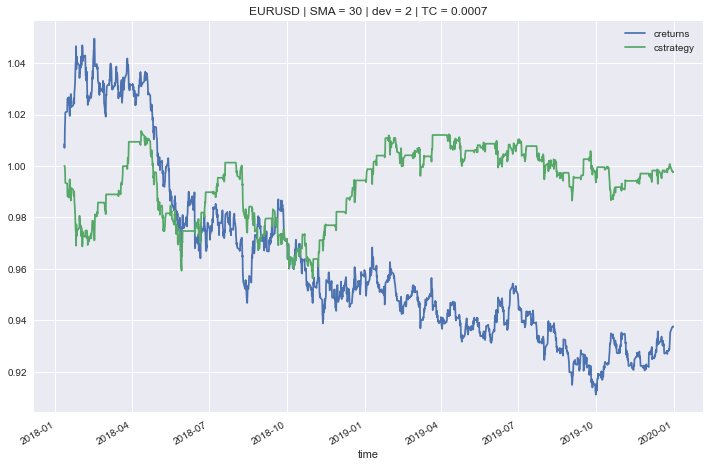

In [7]:
tester.plot_results()

In [8]:
tester.optimize_parameters((25, 100, 1), (1, 5, 1))

(array([43.,  2.]), 1.142512)

In [9]:
tester.test_strategy()

(1.142512, 0.226411)

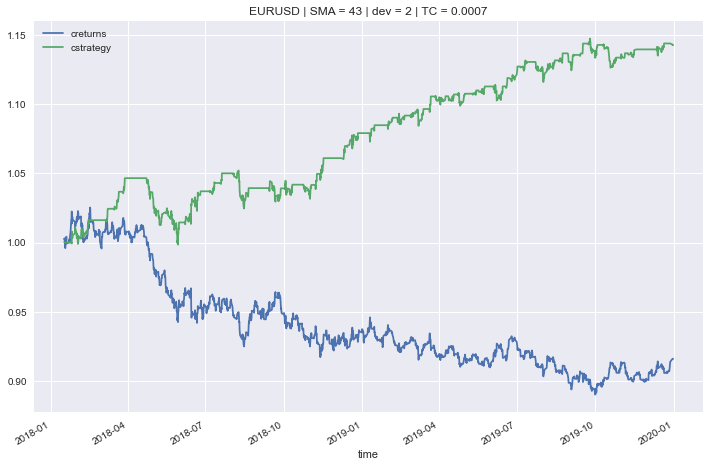

In [10]:
tester.plot_results()

In [11]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
time,,,,,,,,,,,
2018-01-16 16:00:00+00:00,1.226070,0.002540,1.206296,1.185220,1.227371,0.019774,0.0,0.000000,0.0,1.002543,1.000000
2018-01-16 22:00:00+00:00,1.226720,0.000530,1.206753,1.184776,1.228730,0.019967,0.0,0.000000,0.0,1.003075,1.000000
2018-01-17 04:00:00+00:00,1.223655,-0.002502,1.207200,1.184641,1.229758,0.016455,0.0,-0.000000,0.0,1.000568,1.000000
2018-01-17 10:00:00+00:00,1.224275,0.000507,1.207630,1.184484,1.230775,0.016645,0.0,0.000000,0.0,1.001075,1.000000
2018-01-17 16:00:00+00:00,1.218540,-0.004695,1.207952,1.184589,1.231314,0.010588,0.0,-0.000000,0.0,0.996386,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,1.112280,1.106117,1.118443,0.007640,-1.0,-0.000700,1.0,0.915745,1.142956
2019-12-30 04:00:00+00:00,1.119940,0.000018,1.112471,1.105884,1.119059,0.007469,-1.0,-0.000018,0.0,0.915762,1.142935
2019-12-30 10:00:00+00:00,1.120095,0.000138,1.112634,1.105650,1.119619,0.007461,-1.0,-0.000138,0.0,0.915889,1.142777
